<center>
  <h1><b>PGM Project : Capturing label characteristics in VAEs</b></h1>
  <br>
  22 / 12 / 2023
  <br>
  <br>
  <b>Students name:</b>  Biel & David & Aissa
</center>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split,Dataset
from torchvision import  transforms, utils
from torchvision.datasets import MNIST
from torch.distributions import Normal
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import zipfile
import os
import torchvision.utils as vutils


## Dataset

In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/dataset/archive (2).zip'
extracted_dir = '/content/drive/MyDrive/dataset'
os.makedirs(extracted_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transformation for your data (modify as needed)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Create a dataset
dataset = datasets.ImageFolder(root=extracted_dir, transform=transform)

validation_ratio = 0.2
dataset_size = len(dataset)
validation_size = int(validation_ratio * dataset_size)
train_size = dataset_size - validation_size

# Step 5: Split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Step 6: Create DataLoaders for training and validation
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


# Visualizing Mnist Medical

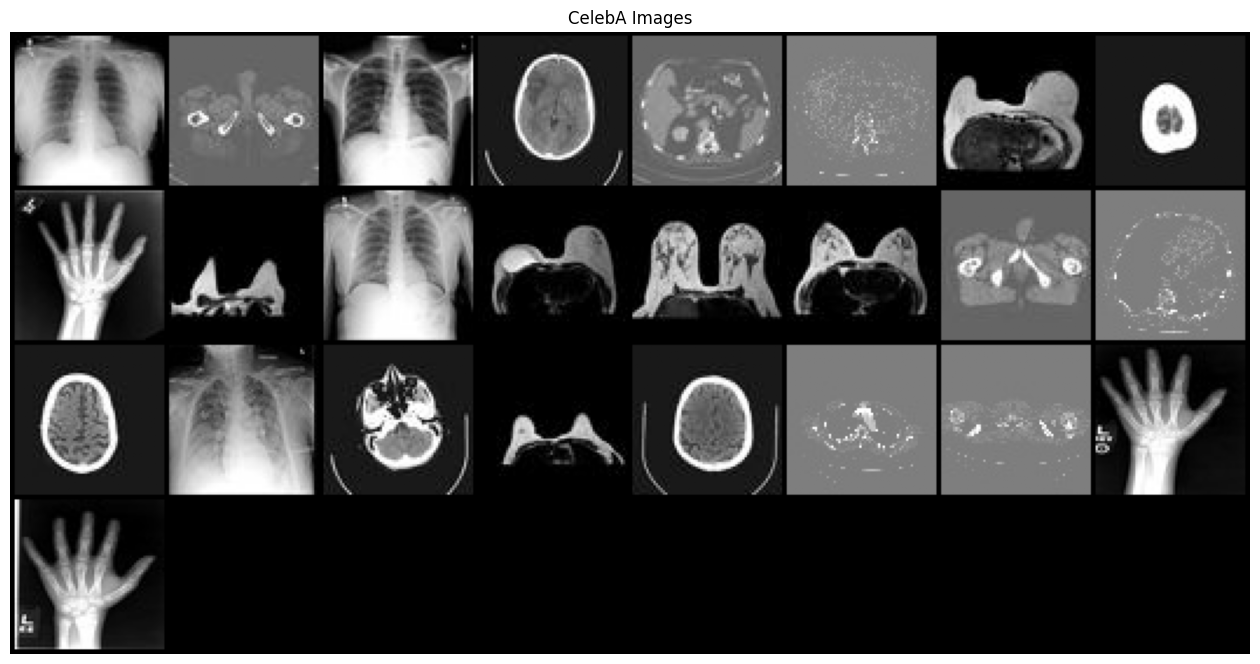

In [ ]:
import numpy as np

# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("CelebA Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:25], padding=2, normalize=True),(1,2,0)))

# Prior
we calculate the distribution of each of the selected attributes in our dataset.

In [ ]:
total_images = 0
class_distribution = torch.zeros(6, 1)

for _, labels in train_dataloader:
    total_images += labels.size(0)
    for label in labels.numpy():
        class_distribution[label] += 1

# Calculate average distribution
mnist_prior = class_distribution / total_images
mnist_prior = mnist_prior.view(1, -1)
# Print the average distribution
print("Average Class Distribution:")
print(mnist_prior)

Average Class Distribution:
tensor([[0.1690, 0.1535, 0.1701, 0.1692, 0.1702, 0.1679]])


# Network

In next cell each of the components of the CCVAE will be defined:

*   Encoder: That predicts the distribution of z given x.
*   Decoder: That predicts x given z.
*   Classifier: That predicts the probabilities of the attributes y given z.
*   CondPrior: That predicts the distribution of z given the attributes y.

In [ ]:

# A utility class for reshaping tensors using the PyTorch nn.Module framework.
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

# A convolutional neural network encoder for the CCVAE.
class CELEBAEncoder(nn.Module):
    def __init__(self, z_dim, hidden_dim=256, *args, **kwargs):
        super().__init__()

        # Setup the convolutional layers
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, hidden_dim, 4, 1),
            nn.ReLU(True),
            View((-1, hidden_dim*1*1))
        )

        # Linear layer computing the mean of the distribution.
        self.locs = nn.Linear(hidden_dim, z_dim)

        # Linear layer computing the variance of the distribution.
        self.scales = nn.Linear(hidden_dim, z_dim)


    def forward(self, x):
        hidden = self.encoder(x)
        return self.locs(hidden), torch.clamp(F.softplus(self.scales(hidden)), min=1e-3)

# A convolutional neural network decoder for the CCVAE.
class CELEBADecoder(nn.Module):
    def __init__(self, z_dim, hidden_dim=256, *args, **kwargs):
        super().__init__()

        self.decoder = nn.Sequential(
            # Setup the
            nn.Linear(z_dim, hidden_dim),
            View((-1, hidden_dim, 1, 1)),

            # Setup the convolutional layers
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim, 128, 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x

# A module to implement a diagonal transformation.
class Diagonal(nn.Module):
    def __init__(self, dim):
        super(Diagonal, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.ones(self.dim))
        self.bias = nn.Parameter(torch.zeros(self.dim))

    def forward(self, x):
        return x * self.weight + self.bias

# A simple classifier model implemented as a neural network
class Classifier(nn.Module):
    def __init__(self, dim):
        super(Classifier, self).__init__()
        self.dim = dim
        self.diag = Diagonal(self.dim)

    def forward(self, x):
        return self.diag(x)

# A model to compute conditional prior distributions.
class CondPrior(nn.Module):
    def __init__(self, dim):
        super(CondPrior, self).__init__()
        self.dim = dim
        self.diag_loc_true = nn.Parameter(torch.zeros(self.dim))
        self.diag_loc_false = nn.Parameter(torch.zeros(self.dim))
        self.diag_scale_true = nn.Parameter(torch.ones(self.dim))
        self.diag_scale_false = nn.Parameter(torch.ones(self.dim))

    def forward(self, x):
        loc = x * self.diag_loc_true + (1 - x) * self.diag_loc_false
        scale = x * self.diag_scale_true + (1 - x) * self.diag_scale_false
        return loc, torch.clamp(F.softplus(scale), min=1e-3)

In [ ]:

class CCVAE(nn.Module):
    def __init__(self, z_dim, num_classes, y_prior_params, use_cuda):
        super(CCVAE, self).__init__()
        self.encoder = CELEBAEncoder(z_dim)
        self.decoder = CELEBADecoder(z_dim)
        self.classifier=Classifier(num_classes)
        self.cond_prior = CondPrior(num_classes)
        self.y_prior_params = y_prior_params
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.use_cuda = use_cuda
        self.ones = torch.ones(1, self.z_dim - self.num_classes)
        self.zeros = torch.zeros(1, self.z_dim - self.num_classes)

        if self.use_cuda:
            self.ones = self.ones.cuda()
            self.zeros = self.zeros.cuda()
            self.y_prior_params = self.y_prior_params.cuda()
            self.cuda()

    # Method to reconstruct an image by encoding and then decoding it.
    def reconstruct_img(self, x):
            return self.decoder(dist.Normal(*self.encoder(x)).rsample())

    # Method that computes the loss of the classifier module for a given x, y
    def classifier_loss(self, x, y, k=100):
        # Sample from the encoder
        zc, _ = dist.Normal(*self.encoder(x)).rsample(torch.tensor([k])).split([self.num_classes, self.z_dim - self.num_classes], -1)
        logits = self.classifier(zc.view(-1, self.num_classes))
        d = dist.Bernoulli(logits=logits)

        # Compute classifier loss
        y = y.expand(k, -1, -1).contiguous().view(-1, self.num_classes)
        lqy_z = d.log_prob(y).view(k, x.shape[0], self.num_classes).sum(dim=-1)
        lqy_x = torch.logsumexp(lqy_z, dim=0) - np.log(k)
        return lqy_x#.mean()

    # Calculate the log likelihood between an original and a reconstructed image
    def img_log_likelihood(self, recon, xs):
        # It returns the log likelihood between an image and its encoder-decoder
        # reconstruction.
        return dist.Laplace(recon, torch.ones_like(recon)).log_prob(xs).sum(dim=(1,2,3))

    # Compute the prior distribution for the attributes, p(y)
    def computer_prior_distribution(self, y, batch_size):
        return dist.Bernoulli(self.y_prior_params.expand(batch_size, -1)).log_prob(y).sum(dim=-1)

    # Compute the KL divergence for the given distributions.
    # In this case, it returns the KL distance between q(zc|x) and p(zc|y)
    def compute_kl(self, mean_q_zc, variance_q_zc, mean_p_zc, variance_p_zc):
        if mean_p_zc is None:
            mean_p_zc = torch.zeros_like(mean_q_zc)
        if variance_p_zc is None:
            variance_p_zc = torch.ones_like(variance_q_zc)

        dist_q = dist.Normal(mean_q_zc, variance_q_zc)
        dist_p = dist.Normal(mean_p_zc, variance_p_zc)
        return dist.kl.kl_divergence(dist_q, dist_p).sum(dim=-1)

    # Returns a partition of the latent space into characteristics and style components.
    def get_latent_space_partition(self, z):
        zc, zs = z.split([self.num_classes, self.z_dim - self.num_classes], 1)
        return zc, zs

    # Calculate the distribution q(y|zc)
    def computer_prior_given_latent_distribution(self, y, zc, propagate):
        if propagate:
            qyzc = dist.Bernoulli(logits=self.classifier(zc))
            return qyzc.log_prob(y).sum(dim=-1)
        else:
            return dist.Bernoulli(logits=self.classifier(zc.detach())).log_prob(y).sum(dim=-1)

    # Compute the overall loss function of the CCVAE
    def ccvae_loss_function(self, x, y):

        batch_size = x.shape[0]

        # Get the outputs of each submodel
        mean_q_z, variance_q_z = self.encoder(x)

        z = dist.Normal(mean_q_z, variance_q_z).rsample()
        zc, zs = self.get_latent_space_partition(z)

        recon = self.decoder(z)

        mean_p_zc, variance_p_zc = self.cond_prior(y)
        mean_p_zc = torch.cat([mean_p_zc, self.zeros.expand(batch_size, -1)], dim=1)
        variance_p_zc = torch.cat([variance_p_zc, self.ones.expand(batch_size, -1)], dim=1)

        # Get distributions
        log_py = self.computer_prior_distribution(y, batch_size)
        log_pxz = self.img_log_likelihood(recon, x)
        log_qyzc_propagate = self.computer_prior_given_latent_distribution(y, zc, True)
        log_qyzc_no_propagate_ = dist.Bernoulli(logits=self.classifier(zc.detach())).log_prob(y).sum(dim=-1)
        log_qyx = self.classifier_loss(x, y)

        # Compute KL
        dkl = self.compute_kl(mean_q_z, variance_q_z, mean_p_zc, variance_p_zc)

        # Compute elbo
        elbo = (torch.exp(log_qyzc_no_propagate_ - log_qyx) * (log_pxz - dkl - log_qyzc_propagate) + log_py + log_qyx).mean()

        return -elbo

    # Method to calculate the classification accuracy of the model for the given x,y
    def classifier_acc(self, x, y=None, k=1):
        # Sample the latent space and split into characteristic and style components
        zc, _ = dist.Normal(*self.encoder(x)).rsample(torch.tensor([k])).split([self.num_classes, self.z_dim - self.num_classes], -1)

        # Predict by applying sigmoid and rounding, then compare with true labels
        logits = self.classifier(zc.view(-1, self.num_classes)).view(-1, self.num_classes)
        y = y.expand(k, -1, -1).contiguous().view(-1, self.num_classes)
        preds = torch.round(torch.sigmoid(logits))

        # Compute accuracy
        acc = (preds.eq(y)).float().mean()
        return acc


# Train the Model
Before training the model, let's choose an image that will serve as an example to see how the reconstruction of the encoded images progress across the training.

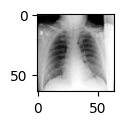

In [ ]:
example = train_dataset[7][0]
plt.figure(figsize=(1,1))
plt.imshow(example.permute(1, 2, 0))
plt.show()

In [ ]:
def plot_image_recon(image, model):
  recon = model.reconstruct_img(image.cuda()).cpu().squeeze()
  recon = recon.permute(1,2,0)
  with torch.no_grad():
    plt.figure(figsize=(1,1))
    plt.imshow(recon)
    plt.show()
def one_hot_encode(labels, num_classes):
    return F.one_hot(labels, num_classes)

Define the parameters of the training.

In [ ]:
num_classes = 6  # Medical MNIST has 6 classes
img_shape = (3, 64, 64)
cc_vae = CCVAE(45, num_classes, mnist_prior, True) #CCVAE Model
optim = torch.optim.Adam(cc_vae.parameters(), lr = 0.002) #Adam optimizer

<ipython-input-25-3cad37128a2f>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = torch.tensor(one_hot_encode(ys, num_classes)).clone().detach()
<ipython-input-25-3cad37128a2f>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = torch.tensor(one_hot_encode(ys, num_classes))


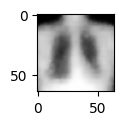

Epoch 0, Loss: 13755754.758789062, train accuracy: 0.9993321299552917, Val accuracy: 0.9995908141136169


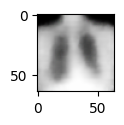

Epoch 1, Loss: 13646845.294921875, train accuracy: 0.9998939037322998, Val accuracy: 0.9995483756065369


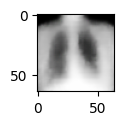

Epoch 2, Loss: 13602307.341796875, train accuracy: 0.9999434351921082, Val accuracy: 0.999562680721283


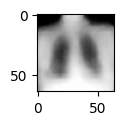

Epoch 3, Loss: 13632500.420898438, train accuracy: 0.9997844696044922, Val accuracy: 0.9995485544204712


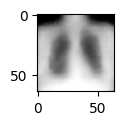

Epoch 4, Loss: 13679822.404785156, train accuracy: 0.999127209186554, Val accuracy: 0.9992803931236267


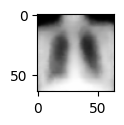

Epoch 5, Loss: 13572342.393554688, train accuracy: 0.9999682903289795, Val accuracy: 0.9995766878128052


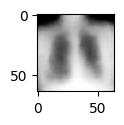

Epoch 6, Loss: 13524742.232421875, train accuracy: 0.9999858736991882, Val accuracy: 0.999703586101532


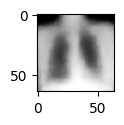

Epoch 7, Loss: 13491825.162109375, train accuracy: 1.0, Val accuracy: 0.9997743368148804


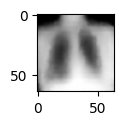

Epoch 8, Loss: 13467009.685546875, train accuracy: 1.0, Val accuracy: 0.9997742176055908


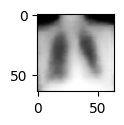

Epoch 9, Loss: 13445717.26953125, train accuracy: 1.0, Val accuracy: 0.9998025298118591
[9332.26238723817, 9258.375369689196, 9228.15966200602, 9248.643433445344, 9280.747900125614, 9207.830660484862, 9175.53747111389, 9153.205673072845, 9136.37020729096, 9121.924877565298]


In [ ]:
# Define the path where checkpoints will be saved
path_to_save = '/content/drive/MyDrive/PGM/ccvae/checkpoints/final_experiment3'
os.makedirs(path_to_save, exist_ok=True)

best_accuracy = 0  # Initialize the best accuracy
train_losses=[]
train_acc=[]
val_acc=[]

for epoch in range(number_epoch):
    epoch_losses_sup = 0
    train_accuracy = 0.0

    # Train the model
    for batch_idx, (xs, ys) in enumerate(train_dataloader):
      cc_vae.train()
      xs = xs.cuda()
      ys = [y.float() for y in ys]
      ys = torch.stack(ys).T.cuda()
      loss = cc_vae.ccvae_loss_function(xs, ys)
      epoch_losses_sup += loss.detach().item()
      loss.backward()
      optim.step()
      optim.zero_grad()

      # Compute training accuracy
      batch_acc = cc_vae.classifier_acc(xs, ys)
      train_accuracy += batch_acc

    # Track training accuracy and loss
    train_accuracy = train_accuracy / len(train_dataloader)
    train_loss=epoch_losses_sup/len(train_dataloader)
    train_acc.append(train_accuracy.cpu())
    train_losses.append(train_loss)

    # Compute and track validation accuracy
    cc_vae.eval()
    validation_accuracy = 0.0
    for batch_idx, (xs, ys) in enumerate(validation_dataloader):
      xs = xs.cuda()
      ys = [y.float() for y in ys]
      ys = torch.stack(ys).T.cuda()
      batch_acc = cc_vae.classifier_acc(xs, ys)
      validation_accuracy += batch_acc

    validation_accuracy = validation_accuracy / len(validation_dataloader)
    val_acc.append(validation_accuracy.cpu())

    # Plot the reconstructed image for this epoch
    with torch.no_grad():
        plot_image_recon(example, cc_vae)

    # Print the epoch loss and the accuracies
    print(f"Epoch {epoch}, Loss: {epoch_losses_sup}, train accuracy: {train_accuracy}, Val accuracy: {validation_accuracy}")

    # Save the current state of the model.
    torch.save(cc_vae.state_dict(), os.path.join(path_to_save, f'checkpoint_epoch_{epoch}.pt'))

    # Check if this is the best accuracy so far and save if it is
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        torch.save(cc_vae.state_dict(), os.path.join(path_to_save, 'best_accuracy_checkpoint.pt'))

In [ ]:
cc_vae = CCVAE(45, 10, mnist_prior, True)
checkpoint_path = "/content/final_experiment_Mnist_Fashion/best_accuracy_checkpoint.pt"
checkpoint = torch.load(checkpoint_path)
cc_vae.load_state_dict(checkpoint)
cc_vae.eval()

This function, `latent_walk_single_axis`, performs a latent space exploration along a single attribute axis for each class in the Medical Fashion dataset. It visually demonstrates how changes in the latent space affect generated facial attributes.




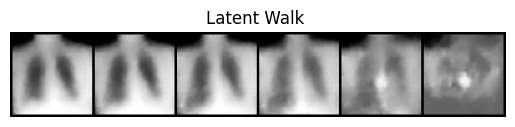

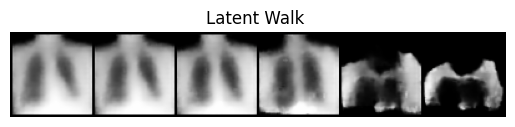

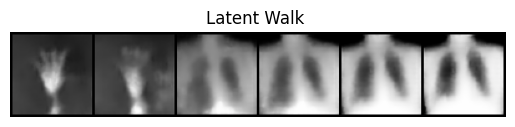

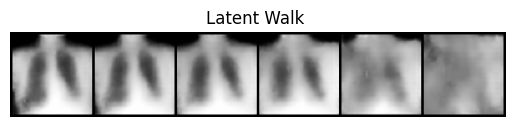

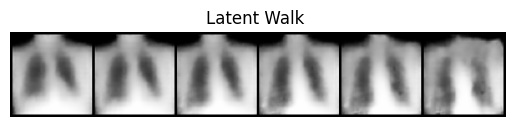

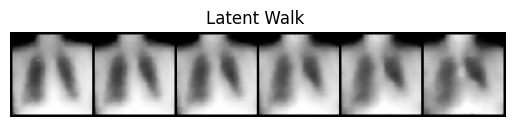

In [ ]:

def latent_walk_single_axis(num_classes, im_shape, image, save_dir, model, num_steps=6, display_grid=True):
    device = next(model.parameters()).device
    mult = 5

    # Ensure the image is on the same device as the model
    image = image.to(device)

    # Sample from the latent space
    z_ = dist.Normal(*model.encoder(image.unsqueeze(0))).sample()[0]

    for i in range(num_classes):
        y = torch.zeros(1, num_classes).to(device)
        locs_false, scales_false = model.cond_prior(y)
        y[:, i].fill_(1.0)
        locs_true, scales_true = model.cond_prior(y)
        sign = torch.sign(locs_true[:, i] - locs_false[:, i])

        z_false_lim = (locs_false[:, i] - mult * sign * scales_false[:, i]).item()
        z_true_lim = (locs_true[:, i] + mult * sign * scales_true[:, i]).item()

        # Construct the range for the latent variable
        z_range = torch.linspace(z_false_lim, z_true_lim, num_steps)

        # Generate images for each step in the latent space
        imgs = []
        for z_val in z_range:
            z = z_.clone()
            z[i] = z_val
            img = model.decoder(z.unsqueeze(0)).view(*im_shape)
            imgs.append(img)

        # Create a grid of images
        grid = make_grid(imgs, nrow=num_steps)
        #save_image(grid, os.path.join(save_dir, f"latent_walk_{CELEBA_EASY_LABELS[i]}.png"))

        # Display the grid
        if display_grid:
            plt.imshow(to_pil_image(grid))
            plt.title(f"Latent Walk - {CELEBA_EASY_LABELS[i]}")
            plt.axis('off')
            plt.show()

num_classes = 6
img_shape = (3, 64, 64)  # Define the shape of the image
save_dir = "/content/final_experiment3"
latent_walk_single_axis(num_classes, img_shape, example, save_dir, cc_vae)
